In [1]:
#import libraries
import pysmu
from pysmu import Session, Mode, Device
import time
import pandas as pd
import matplotlib.pyplot as plt
import os
#initialize the session run count to keep recordings in order
run = 1

In [2]:
# initialize ADALM settings
session = Session(queue_size = 100000)
sample_rate = 100000
session.configure(sample_rate = sample_rate)
chA = session.devices[0].channels['A']
chB = session.devices[0].channels['B']

In [3]:
#Total time of stimulation
stim_time = 5 #units: seconds

#time to delay the second signal from the other
delay = 0.5 #unit: seconds

# Channel A set parameters below
chA_voltage = 1 #units: V for voltage stim or A for current stim
chA_pulse_width = 10 #unit: ms
chA_frequency = 1 #unit: Hz

# Channel B set parameters below
chB_voltage = 1 #units: V for voltage stim or A for current stim
chB_pulse_width = 10 #unit: ms
chB_frequency = 1 #unit: Hz

In [4]:
# apply stimulation
for i, stim in enumerate(range(stim_time)):
    #set channel A
    chA.mode = Mode.SVMI
    chA.square(chA_voltage,0,sample_rate/chA_frequency,0,chA_pulse_width/(1000/chA_frequency))
    #set channel B
    chB.mode = Mode.SVMI
    chB.square(chB_voltage,0,sample_rate/chB_frequency,delay*sample_rate,chB_pulse_width/(1000/chA_frequency))
    #stim channels
    recording = session.devices[0].get_samples(stim_time*sample_rate)
    chA.constant(0)
    chB.constant(0)
    session.devices[0].get_samples(10)

   
#save V and A recordings
V_chA = []
A_chA = []
V_chB = []
A_chB = []

for i in range(len(recording)):
    V_chA.append(recording[i][0][0])
    A_chA.append(recording[i][0][1])
    V_chB.append(recording[i][1][0])
    A_chB.append(recording[i][1][1])
df = pd.DataFrame({"Channel 1 V" : V_chA, "Channel 1 A": A_chA, "Channel 2 V" : V_chB, "Channel 2 A": A_chB})
df.to_csv(f"Muscle_stim_{run}.csv")
run += 1
session.end()

In [5]:
# Looks through the folder where this code file is located and selects and orders the recording files
directory = os.getcwd()
data_sets = []
file_names = []

datas = []
names = []
for root,dirs,files in os.walk(directory):
    for file in sorted(files):
        if file.endswith(".csv"):
            if "stim_" in file:
                f=open(file, 'r')
                data = pd.read_csv(f)
                file_name = file.split('.')[0]
                datas.append(data)
                f.close()
                names.append(file_name)
print(names)
print(datas)

['Muscle_stim_1']
[        Unnamed: 0  Channel 1 V  Channel 1 A  Channel 2 V  Channel 2 A
0                0     0.441749     0.004190     0.003624    -0.000251
1                1     0.993946     0.011242     0.003546    -0.000227
2                2     0.999022     0.010969     0.003468    -0.000126
3                3     0.999335     0.010697     0.003546    -0.000165
4                4     0.999491     0.010681     0.003546    -0.000157
...            ...          ...          ...          ...          ...
499995      499995     0.002943     0.000452     0.003624    -0.000243
499996      499996     0.002943     0.000428     0.003468    -0.000173
499997      499997     0.002943     0.000506     0.003468    -0.000220
499998      499998     0.002943     0.000405     0.003468    -0.000204
499999      499999     0.002865     0.000592     0.003546    -0.000267

[500000 rows x 5 columns]]


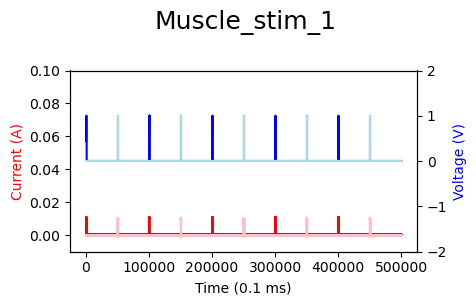

In [38]:
# plots the traces and labels each by channel
for n, name in enumerate(names):
    data = datas[n]
    # add a new subplot iteratively
    plt.figure(figsize=(5,3))
    plt.suptitle(name, fontsize=18, y=1)
    
    ax = plt.subplot()
    # ax.set_xlim(0,100000)
    # Current plot (left y-axis)
    ax.set_xlabel('Time (0.1 ms)')
    ax.set_ylabel('Current (A)', color='red')
    ax.plot(data["Channel 1 A"], color='red', label='Channel 1 Current')
    ax.plot(data["Channel 2 A"], color='pink', label='Channel 2 Current')
    ax.tick_params(axis='y', labelcolor='black')
    ax.set_ylim(-0.01,0.1)

    # Voltage plot (right y-axis)
    axt = ax.twinx()  
    axt.set_ylabel('Voltage (V)', color='blue')
    axt.plot(data["Channel 1 V"], color='blue', label='Channel 1 Voltage')
    axt.plot(data["Channel 2 V"], color='lightblue', label='Channel 2 Voltage')
    axt.tick_params(axis='y', labelcolor='black')
    axt.set_ylim(-2,2)

    plt.tight_layout()
    plt.show()